In [1]:
#VIERNES A LAS 13:00
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import wrf
# ds083  GFS    NAM
# 1deg   0.5deg  12km
# p1s1   p2s2   p7s7
# https://www.ncdc.noaa.gov/data-access/model-data/model-datasets/north-american-mesoscale-forecast-system-nam
# https://www.ncdc.noaa.gov/data-access/model-data/model-datasets/global-forcast-system-gfs


from wrf import getvar, vinterp, ALL_TIMES, destagger, to_np, interplevel, vertcross, CoordPair, latlon_coords
from matplotlib.cm import get_cmap
from matplotlib.ticker import FormatStrFormatter
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from wrf import smooth2d, get_cartopy, cartopy_xlim, cartopy_ylim

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
np.set_printoptions(precision=2)

In [2]:
expruns = ['20120816_d03_gfs05_p1r1', '20120816_d03_gfs05_p1r3','20120816_d03_gfs05_p1r5',
           '20120816_d03_gfs05_p2r1', '20120816_d03_gfs05_p2r3','20120816_d03_gfs05_p2r5',
           '20120816_d03_nam32_p1r1', '20120816_d03_nam32_p1r3','20120816_d03_nam32_p1r5',
           '20120816_d03_nam32_p2r1', '20120816_d03_nam32_p2r3','20120816_d03_nam32_p2r5' ]
expnames = ['g1r1', 'g1r3', 'g1r5', 'g2r1', 'g2r3', 'g2r5', 
            'n1r1', 'n1r3', 'n1r5', 'n2r1', 'n2r3', 'n2r5']
zlev = ['30m', '40m', '50m', '100m', '150m', '200m', '250m', '300m', '350m', '400m', '450m', '500m']

expruns[7]

'20120816_d03_nam32_p1r3'

In [3]:
d1 = '/media/rello/HDD/d03/'
d2 = '../../../../../d03/'
d3 = '../../../Rello/D03/'
f = d3+expruns[5]+'.nc'
print(f)


../../../Rello/D03/20120816_d03_gfs05_p2r5.nc


In [4]:
# READ WRF INTERP DATA
idw = [0,2,3,4,5,6,7,8,9,10,11]
ids = [0,1,2,7,12,17,22,27,32,37,42,47]
t1, t2, t3, t4 = '2012-08-16 12:30', '2012-08-17 12:00', '2012-08-18 12:00', '2012-08-19 12:00'
t1, t4 = '2012-08-17 00:00', '2012-08-19 00:00'
tt1, tt4 = 24, 120

sread_w =  pd.read_pickle('sodar_sp.pk')
sread_d =  pd.read_pickle('sodar_dd.pk')
sread_t =  pd.read_pickle('sodar_tv.pk')

sodarw =  sread_w.iloc[:,ids][t1:t4].interpolate().values
sodard =  sread_d.iloc[:,ids][t1:t4].interpolate().values
sodart =  sread_t.iloc[:,ids][t1:t4].interpolate().values
stime = sread_w.iloc[:,ids][t1:t4]

xt = sread_w.iloc[::3,ids]['2012-08-17 00:00':'2012-08-19 00:00'].index
wrftime = to_np(xr.open_dataset('interp30/sodar_g1r1.nc')['uv30'][tt1:tt4].Time)

date1, date2 = wrftime[0], wrftime[wrftime.size-1]
print(wrftime.size, date1, date2)

96 2012-08-17T00:00:00.000000000 2012-08-18T23:30:00.000000000


In [5]:
xp = 0 
tt = 0
def utcwrf(tt, timedelta):   
    ttw = 0+tt*3 # Se le suman 12 horas (72 dt) para el comenzar en fecha 17 agosto
    fd =d3+expruns[xp]+'.nc'
    ncfile = Dataset(fd)  
    wa = getvar(ncfile, "wa", units="m s-1", timeidx=ttw)
    wt = to_np(wa[0,0,0].Time)
    localt = wt + np.timedelta64(timedelta, 'h')
    t = pd.to_datetime(str(localt))
    sodartp = stime.index[tt]
    print('ncwrf ', wt, 'nclocalt ', t,  'sodart', sodartp)
    return(ttw, t, sodartp)
        
timedelta = -6
ttw, t, _ = utcwrf(tt, timedelta)

ncwrf  2012-08-16T18:00:00.000000000 nclocalt  2012-08-16 12:00:00 sodart 2012-08-17 00:00:00


In [6]:
#xr.open_dataset('../../../../../d03/'+expruns[0]+'.nc')
# Time: 433,
#  START_DATE:                      2012-08-16_18:00:00    10 AM LOCAL
#  END_DATE:                        2012-08-19_18:00:00

# Dimensions:                (Time: 433, bottom_top: 29, bottom_top_stag: 30, soil_layers_stag: 4, south_north: 30, 
#                              south_north_stag: 31, west_east: 30, west_east_stag: 31)
#    DX:                              950.0
#    DY:                              950.0
#    TITLE:                          OUTPUT FROM WRF V3.9.1.1 MODEL

In [26]:
xp=4
tt=0
angle=30
vmax=13.5
zbot=1
ztop=9

fd =d3+expruns[xp]+'.nc'
ncfile = Dataset(fd)
ttw, t, _ = utcwrf(tt, timedelta)
#########
uv, wd = getvar(ncfile, "wspd_wdir", units="m s-1", timeidx=ttw)   
wa = getvar(ncfile, "wa", units="m s-1", timeidx=ttw)
tv = getvar(ncfile, "tv", units="degC", timeidx=ttw)
z = getvar(ncfile, "z", units="m", timeidx=ttw)
# Define a pivot point and angle in grid coordinates
pivot_point = CoordPair(x=23, y=26)


# Calculate the vertical cross section.  By setting latlon to True, this
uv_vert = vertcross(uv, z, pivot_point=pivot_point, angle=angle, latlon=True)[zbot:ztop,:]
#uv_vert = np.absolute(uv_vert)
wd_vert = vertcross(wd, z, pivot_point=pivot_point, angle=angle, latlon=True)[zbot:ztop,:]
uv_pver = uv_vert*np.cos(np.radians(wd_vert-angle)) 
uv_pver = np.absolute(uv_pver)
w_vert = vertcross(wa, z, pivot_point=pivot_point, angle=angle, latlon=True)[zbot:ztop,:]
tv_vert = vertcross(tv, z, pivot_point=pivot_point, angle=angle, latlon=True)[zbot:ztop,:]
z_vert = uv_vert.vertical.values

coord_pairs = to_np(uv_vert.coords["xy_loc"])

lats, lons = {}, {}
for i in range(coord_pairs.size):
    lats[i] = uv_vert.xy_loc.values[i].lat
    lons[i] = uv_vert.xy_loc.values[i].lon

lons = np.array(list(lons.values()))
lats = np.array(list(lats.values()))
LONS, ZHOV = np.meshgrid(lons, z_vert)

np.arange(zbot,ztop-zbot,1)*200

xlons = np.arange(lons.size)
nlev=ztop-zbot
zvert = np.arange(zbot,nlev+1,1)*200
LONS, ZHOV = np.meshgrid(xlons, zvert)

ncwrf  2012-08-16T18:00:00.000000000 nclocalt  2012-08-16 12:00:00 sodart 2012-08-17 00:00:00


fig, ax = plt.subplots(1, 1)

vmin, vmax = 0, vmax
levels = np.arange(vmin, vmax, 0.5)
CF = ax.contourf(LONS, ZHOV, uv_pver, levels=levels, vmin=vmin, vmax=vmax, cmap=plt.cm.jet)  
fig.colorbar(CF, ax=ax)

CS = ax.contour(LONS, ZHOV, tv_vert, colors='whitesmoke')
ax.clabel(CS, inline=1, fmt='%2.1f', colors='whitesmoke', fontsize=8)

Q = ax.quiver(LONS[:,::2], ZHOV[:,::2], uv_pver[:,::2], w_vert[:,::2], pivot='mid', width=0.0030)
ax.quiverkey(Q, X=0.75, Y=1.10, U=5, label=' 5 m/s', labelpos='E');

ax.set_facecolor('mediumspringgreen')

In [27]:
def hovtSBuv0(xp,tt,angle,vmax,zbot,ztop):
    fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12,6))
    fig.subplots_adjust(left=0.08, right=0.98, wspace=0.04)
    axs[0,0].set_ylabel('Altitud [m]')
    axs[1,0].set_ylabel('Altitud [m]')
       
    fd =d3+expruns[xp]+'.nc'
    ncfile = Dataset(fd)  

    ttw, t, _ = utcwrf(tt, timedelta)

    fig.suptitle('Brisa Marina '+t.strftime('%d-Ago %H:%Mh'), fontsize=16) 
    
    for line in range(2):
        for cols in range(3):
            ax = axs[line,cols]        
            fd =d3+expruns[xp]+'.nc'
            ncfile = Dataset(fd)
#########
            uv, wd = getvar(ncfile, "wspd_wdir", units="m s-1", timeidx=ttw)   
            wa = getvar(ncfile, "wa", units="m s-1", timeidx=ttw)
            tv = getvar(ncfile, "tv", units="degC", timeidx=ttw)
            z = getvar(ncfile, "z", units="m", timeidx=ttw)
            # Define a pivot point and angle in grid coordinates
            pivot_point = CoordPair(x=23, y=26)

            # Calculate the vertical cross section.  By setting latlon to True, this
            uv_vert = vertcross(uv, z, pivot_point=pivot_point, angle=angle, latlon=True)[zbot:ztop,:]
            wd_vert = vertcross(wd, z, pivot_point=pivot_point, angle=angle, latlon=True)[zbot:ztop,:]
            uv_pver = uv_vert*np.cos(np.radians(wd_vert-angle)) 
            uv_abs = np.absolute(uv_pver)
            w_vert = vertcross(wa, z, pivot_point=pivot_point, angle=angle, latlon=True)[zbot:ztop,:]
            tv_vert = vertcross(tv, z, pivot_point=pivot_point, angle=angle, latlon=True)[zbot:ztop,:]
            z_vert = uv_vert.vertical.values
            coord_pairs = to_np(uv_vert.coords["xy_loc"])
##########
            if xp == 0 or xp == 6:
                lats, lons = {}, {}
                for i in range(coord_pairs.size):
                    lats[i] = uv_vert.xy_loc.values[i].lat
                    lons[i] = uv_vert.xy_loc.values[i].lon

                lons = np.array(list(lons.values()))
                lats = np.array(list(lats.values()))
                LONS, ZHOV = np.meshgrid(lons, z_vert)
                
                coords = []*lats.size
                for k in range(lats.size):
                    coor = "%0.2f" % (lats[k])+","+"%0.2f" % (lons[k])
                    coords.append(coor)
                
##########            
            axs[line,cols].plot([-103.77]*6,z_vert[3-zbot:9-zbot], color='purple')
            
            vmin, vmax = 0, vmax         
            if vmax == 99:
                CF = axs[line,cols].contourf(LONS, ZHOV, uv_abs, cmap=plt.cm.rainbow)
            else:
                levels = np.arange(vmin,vmax,0.5)
                CF = axs[line,cols].contourf(LONS, ZHOV, uv_abs, levels=levels, vmin=vmin, vmax=vmax, cmap=plt.cm.rainbow)
            fig.colorbar(CF, ax=axs[line,cols])

            Q = axs[line,cols].quiver(LONS[:,::2], ZHOV[:,::2], uv_pver[:,::2], w_vert[:,::2], pivot='mid', scale=100, width=0.0030)
            axs[line,cols].quiverkey(Q, X=0.75, Y=1.10, U=5, label=' 5 m/s', labelpos='E')

            tmin, tmax = 20, 35
            levels = np.arange(tmin, tmax, 1)
            CS = axs[line,cols].contour(LONS, ZHOV, tv_vert, colors='whitesmoke', levels=levels)
            axs[line,cols].clabel(CS, inline=1, fmt='%2.1f', colors='whitesmoke', fontsize=8)
                 
            axs[line,cols].set_facecolor('mediumspringgreen')
            axs[line,cols].set_title(expnames[xp]+'\n', y=0.95, fontsize=10)

            mpl.rc('xtick', labelsize=7) 
            mpl.rc('ytick', labelsize=7)             
            axs[line,cols].set_xticks(lons[4::8])
            axs[line,cols].set_xticklabels(coords[4::8], rotation=18)

            xp += 1
            
# #plt.savefig('figs/Sea Breeze T Axis'+d+'.png', dpi=300)


In [28]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from wrf import to_np, latlon_coords, getvar
# https://matplotlib.org/examples/color/named_colors.html 

def levPlot6(xp,tt,lev,vmax):
    fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(9,6))
    fig.subplots_adjust(left=0.08, right=0.98, wspace=0.04)
                
    fd =d3+expruns[xp]+'.nc'
    ncfile = Dataset(fd)  
        
    timedelta = -6
    ttw, t, _ = utcwrf(tt, timedelta)
    
    fig.suptitle('Brisa Marina '+t.strftime('%d-Ago %H:%Mh')+' @ '+zlev[lev], fontsize=16)
    fig.text(0.0, 0.5, 'Latitud', va='center', rotation='vertical')
    fig.text(0.5, 0.05, 'Longitud', va='center', rotation='horizontal')
    
    for line in range(2):
        for cols in range(3):
            ax = axs[line,cols]   
            axs[line,cols].set_title(expnames[xp]+'\n', y=0.95, fontsize=10)
            axs[line,cols].tick_params(axis="x", rotation=12, labelsize=8) 
            axs[line,cols].tick_params(axis="y", rotation=12, labelsize=8) 
            fd =d3+expruns[xp]+'.nc'
            ncfile = Dataset(fd)            
################
            ua = getvar(ncfile, "ua", units="m s-1", timeidx=ttw)
            va = getvar(ncfile, "va", units="m s-1", timeidx=ttw)
            tv = getvar(ncfile, "tv", units="degC", timeidx=ttw)
            uv, wd = getvar(ncfile, "wspd_wdir", units="m s-1", timeidx=ttw)   
            
            lats, lons = latlon_coords(ua)
            lats, lons = to_np(lats), to_np(lons)
            va = to_np(va[lev,:,:])
            ua = to_np(ua[lev,:,:])
            tv = to_np(tv[lev,:,:])
            UV = to_np(uv[lev,:,:])

################

            axs[line,cols].scatter(lons[24,20],lats[24,20], color='y', edgecolors='w', zorder=5)

            vmin, vmax = 0, vmax 
            levels = np.arange(vmin,vmax,0.5)
            contf = axs[line,cols].contourf(lons, lats, UV, 10, levels=levels, vmin=vmin, vmax=vmax, cmap=plt.cm.jet)
            fig.colorbar(contf, ax=axs[line,cols])

            clevels = np.arange(vmin,35,1)
            CS = axs[line,cols].contour(lons, lats, tv, levels=clevels, colors='w')
            axs[line,cols].clabel(CS, inline=1, fmt='%2.1f', colors='w', fontsize=10)
            
            
            sk = 4
            Q = axs[line,cols].quiver(lons[::sk,::sk], lats[::sk,::sk], ua[::sk,::sk], va[::sk,::sk], scale=60, pivot='mid')
            axs[line,cols].quiverkey(Q, X=0.75, Y=1.07, U=5, label=' 5 m/s', labelpos='E')

            xp+=1

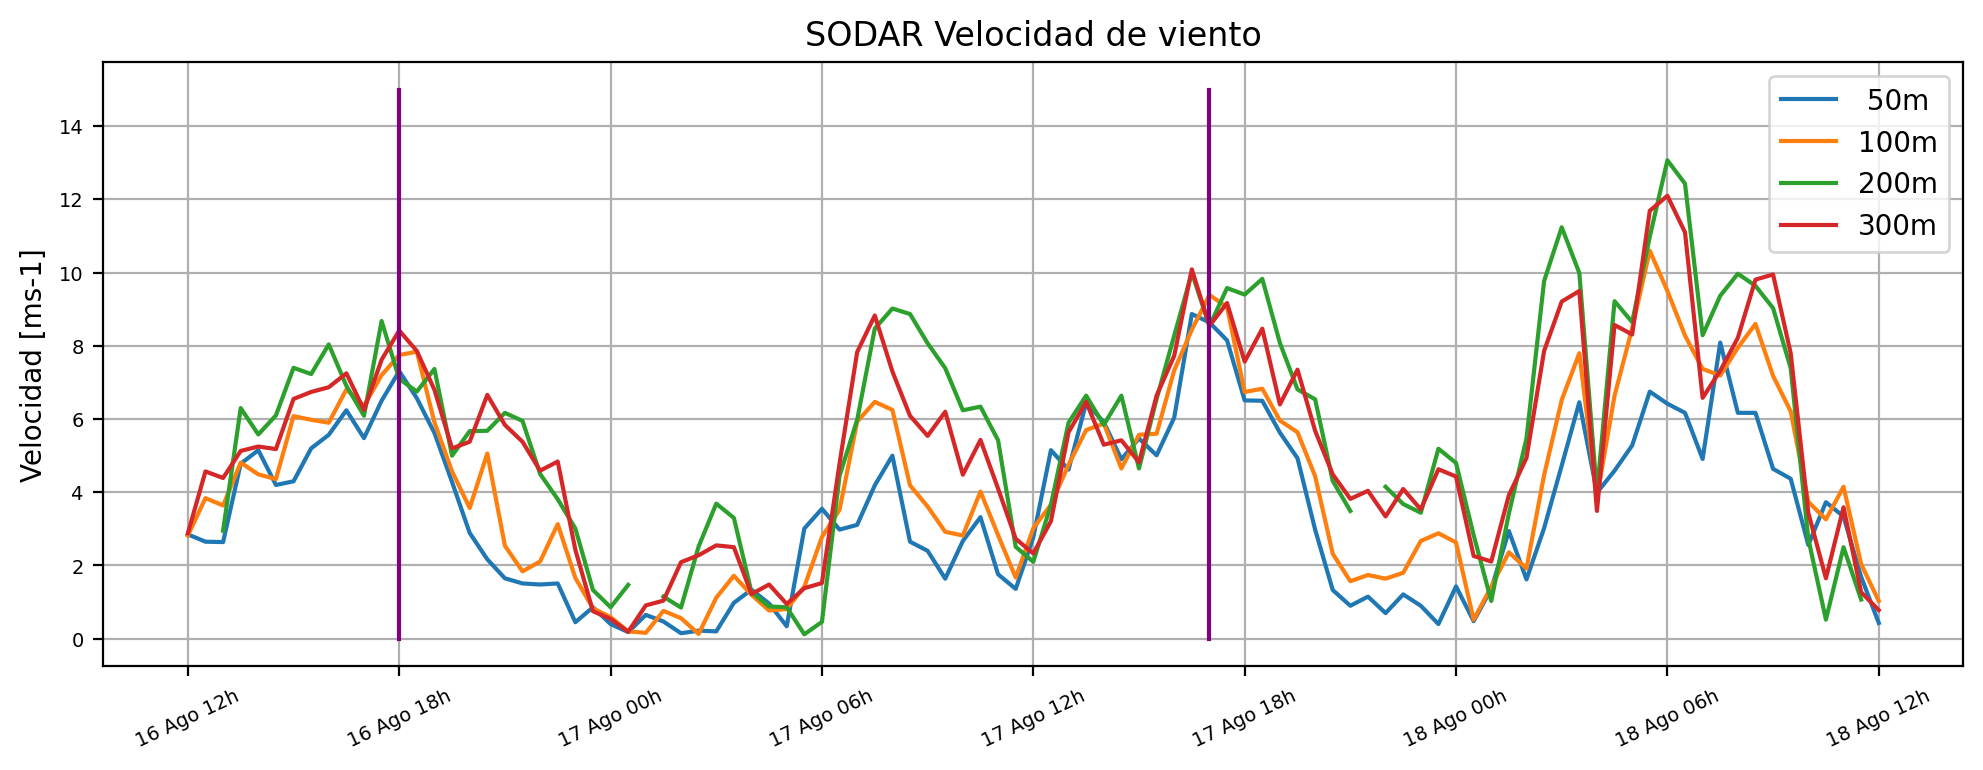

In [29]:
sp = pd.read_pickle('sodar_sp.pk')
t1, t4 = '2012-08-16 12:00', '2012-08-18 12:00'
fig = plt.figure(figsize=[12,4])
s50 =   sp['spd_50'][t1:t4]
s100 =  sp['spd_50'][t1:t4]
s100 = sp['spd_100'][t1:t4]
s200 = sp['spd_300'][t1:t4]
s300 = sp['spd_200'][t1:t4]

nx = s100.size
xdelta = 6
xloc = np.arange(nx)
tickname = s100[::xdelta*2].index.strftime('%d Ago %Hh').tolist()
plt.xticks(np.arange(nx)[::xdelta*2], tickname, rotation=25);
plt.plot(xloc, s50, label=' 50m')
plt.plot(xloc, s100, label='100m')
plt.plot(xloc, s200, label='200m')
plt.plot(xloc, s300, label='300m')

h = 16
plt.plot([12]*h,range(h), color='purple')
plt.plot([58]*h,range(h), color='purple')
#plt.plot([60]*h,range(h), color='purple')
#plt.plot([80]*h,range(h), color='purple')

plt.ylabel('Velocidad [ms-1]')
#plt.xlabel('Fecha')
plt.grid(True)
plt.legend()

plt.title('SODAR Velocidad de viento')
figname='wrf_spd_'
#plt.savefig(dirs+figname+'_'+rtimes+'_'+run+'.png', dpi=300)
plt.show()

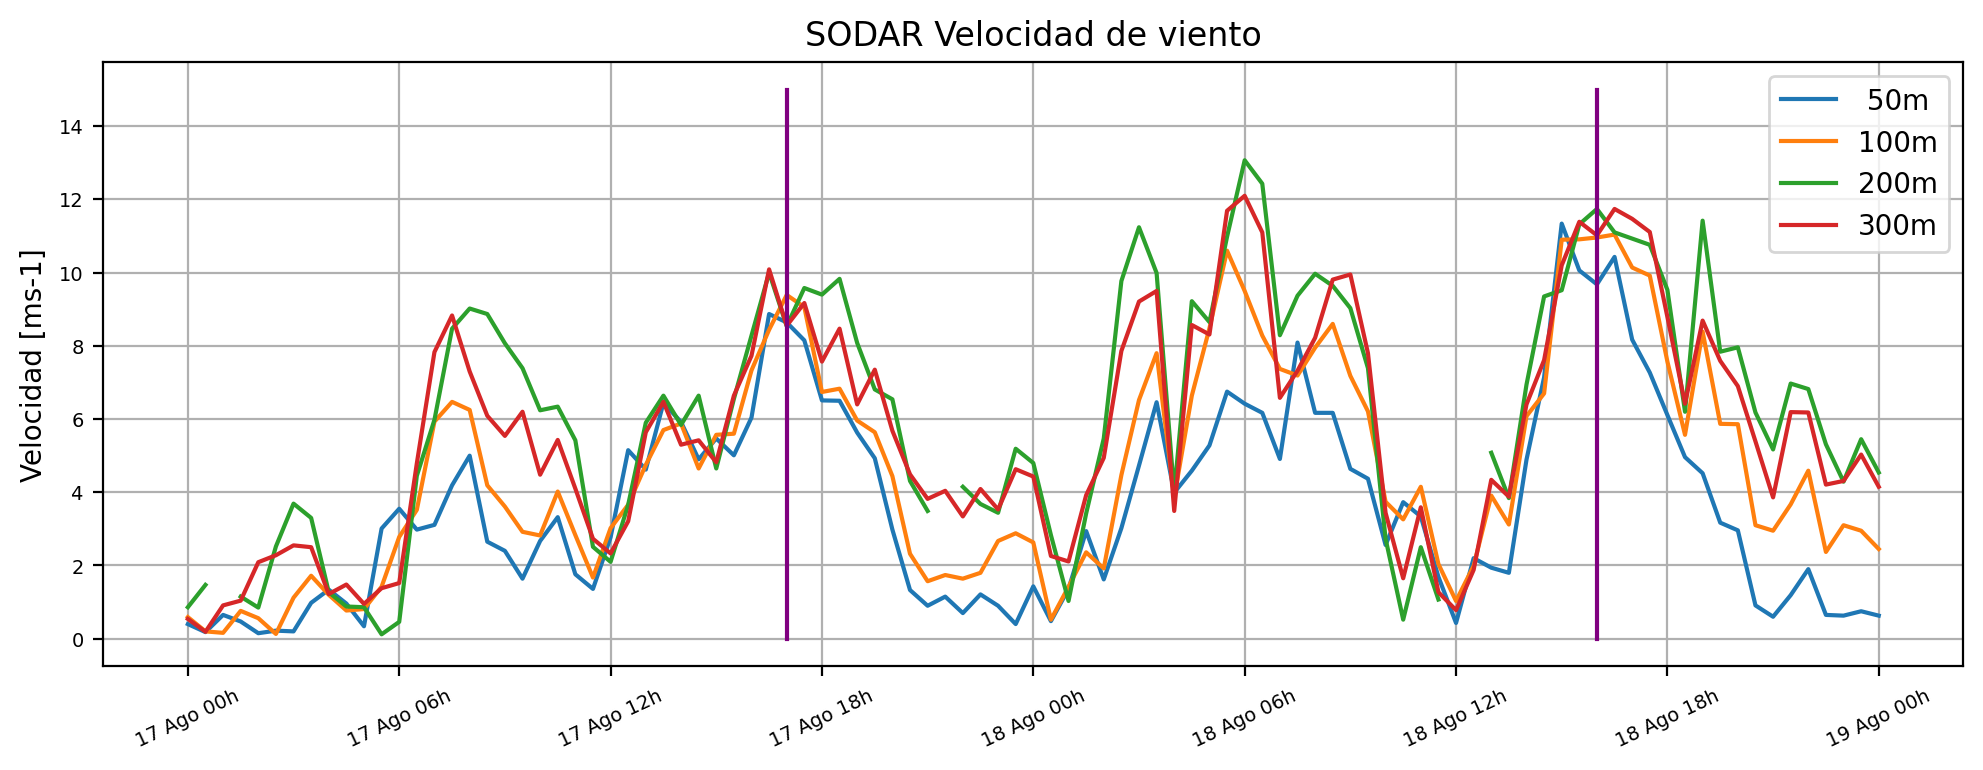

In [30]:
sp = pd.read_pickle('sodar_sp.pk')
t1, t4 = '2012-08-17 00:00', '2012-08-19 00:00'
fig = plt.figure(figsize=[12,4])
s50 =   sp['spd_50'][t1:t4]
s100 =  sp['spd_50'][t1:t4]
s100 = sp['spd_100'][t1:t4]
s200 = sp['spd_300'][t1:t4]
s300 = sp['spd_200'][t1:t4]

nx = s100.size
xdelta = 6
xloc = np.arange(nx)
tickname = s100[::xdelta*2].index.strftime('%d Ago %Hh').tolist()
plt.xticks(np.arange(nx)[::xdelta*2], tickname, rotation=25);
plt.plot(xloc, s50, label=' 50m')
plt.plot(xloc, s100, label='100m')
plt.plot(xloc, s200, label='200m')
plt.plot(xloc, s300, label='300m')

h = 16
#plt.plot([15]*h,range(h), color='purple')
plt.plot([34]*h,range(h), color='purple')
#plt.plot([60]*h,range(h), color='purple')
plt.plot([80]*h,range(h), color='purple')

plt.ylabel('Velocidad [ms-1]')
#plt.xlabel('Fecha')
plt.grid(True)
plt.legend()

plt.title('SODAR Velocidad de viento')
figname='wrf_spd_'
#plt.savefig(dirs+figname+'_'+rtimes+'_'+run+'.png', dpi=300)
plt.show()

ncwrf  2012-08-18T00:00:00.000000000 nclocalt  2012-08-17 18:00:00 sodart 2012-08-18 06:00:00


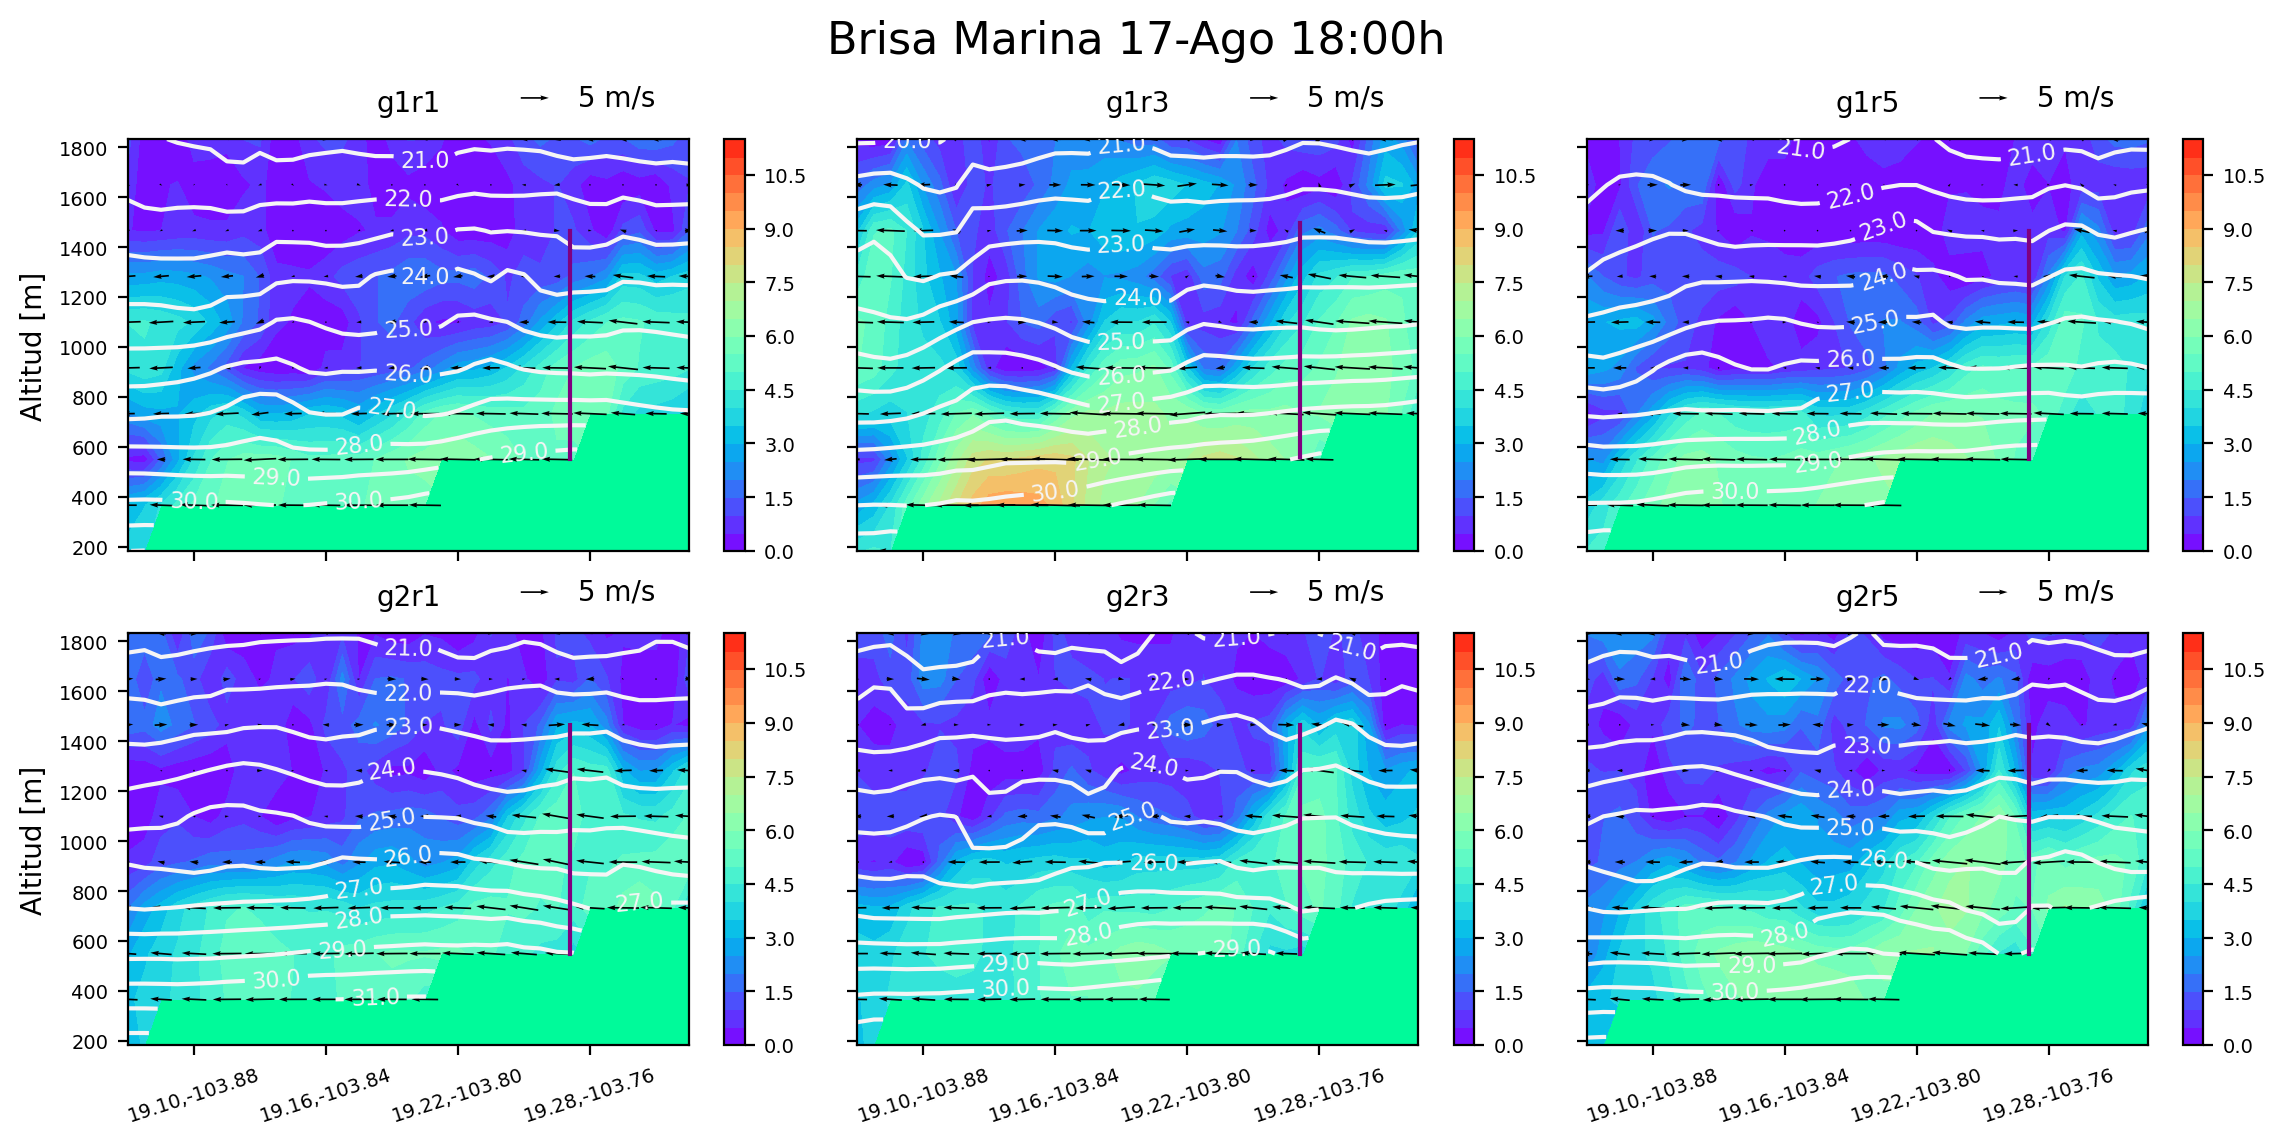

In [32]:
xp=0
tt=60
ang=30
vmax=12
hovtSBuv0(xp=xp,tt=tt,angle=ang,vmax=vmax,zbot=1,ztop=11)

ncwrf  2012-08-18T00:00:00.000000000 nclocalt  2012-08-17 18:00:00 sodart 2012-08-18 06:00:00


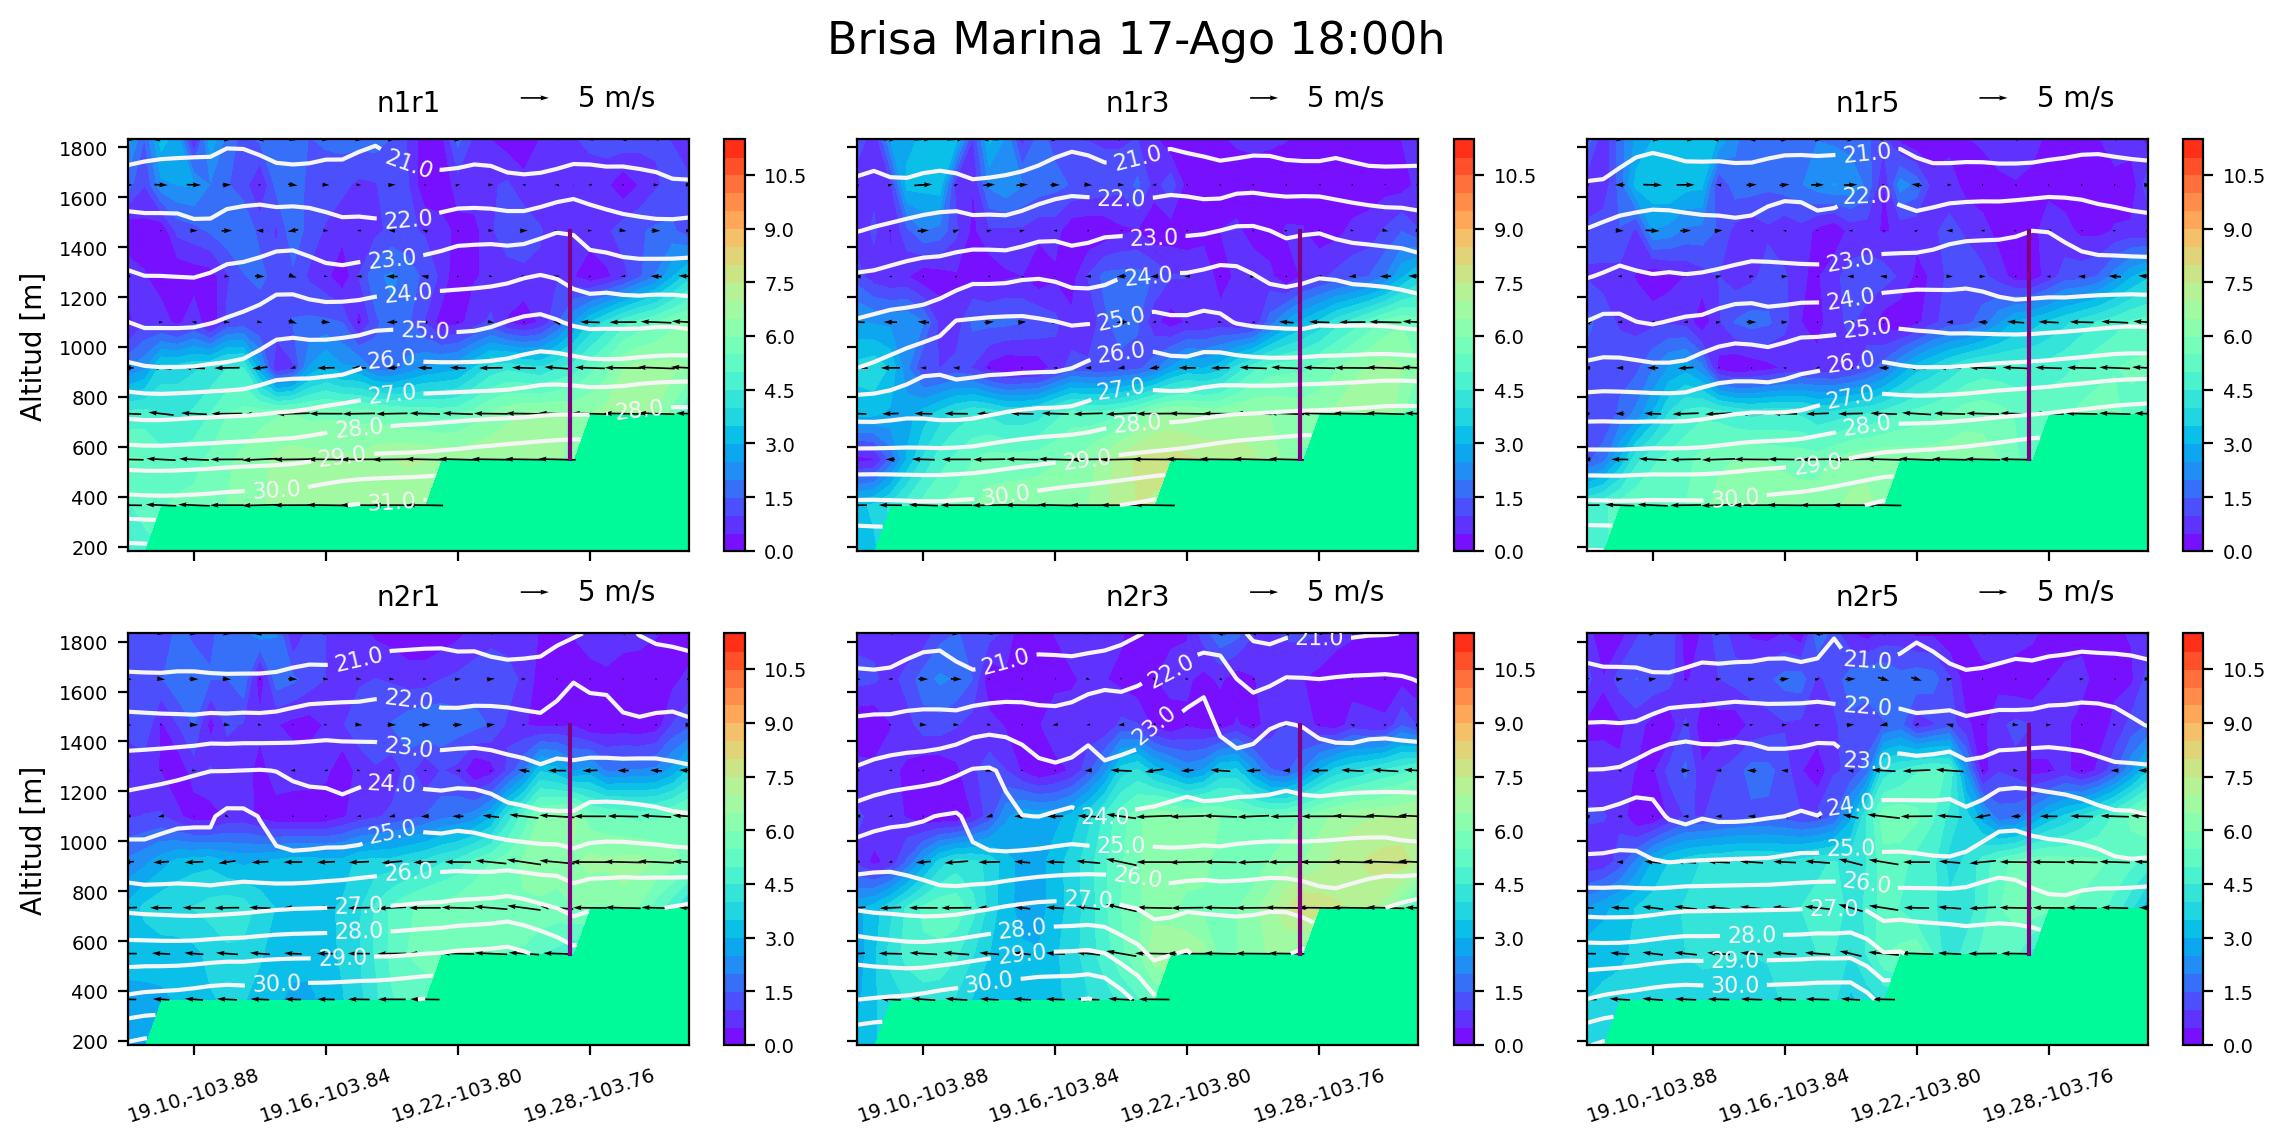

In [34]:
xp=6
tt=60
ang=30
vmax=12
hovtSBuv0(xp=xp,tt=tt,angle=ang,vmax=vmax,zbot=1,ztop=11)

ncwrf  2012-08-18T00:00:00.000000000 nclocalt  2012-08-17 18:00:00 sodart 2012-08-18 06:00:00


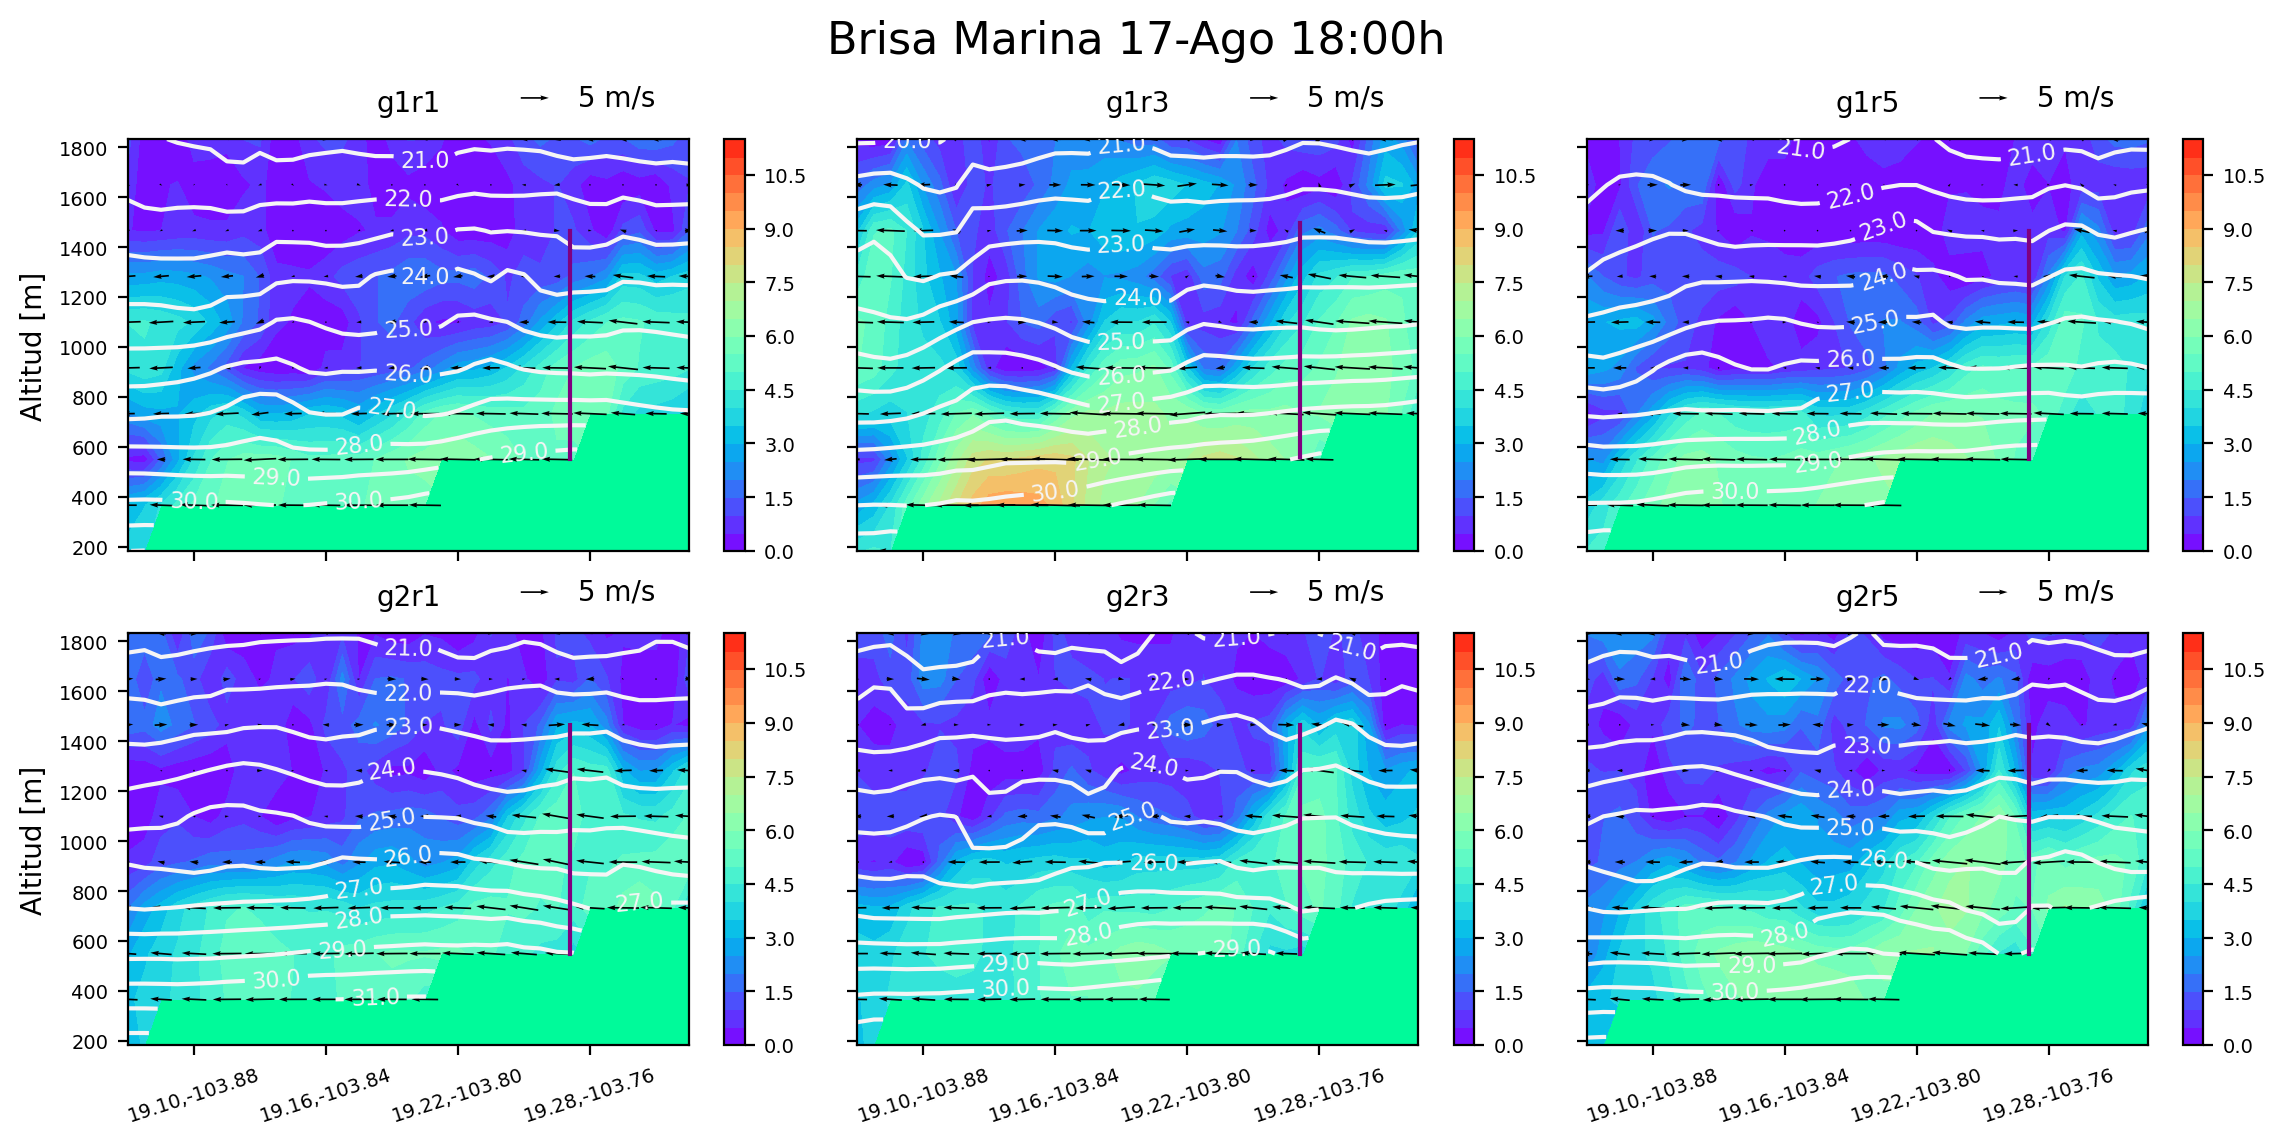

In [35]:
xp=0
tt=60
ang=30
vmax=12
hovtSBuv0(xp=xp,tt=tt,angle=ang,vmax=vmax,zbot=1,ztop=11)

ncwrf  2012-08-18T00:00:00.000000000 nclocalt  2012-08-17 18:00:00 sodart 2012-08-18 06:00:00


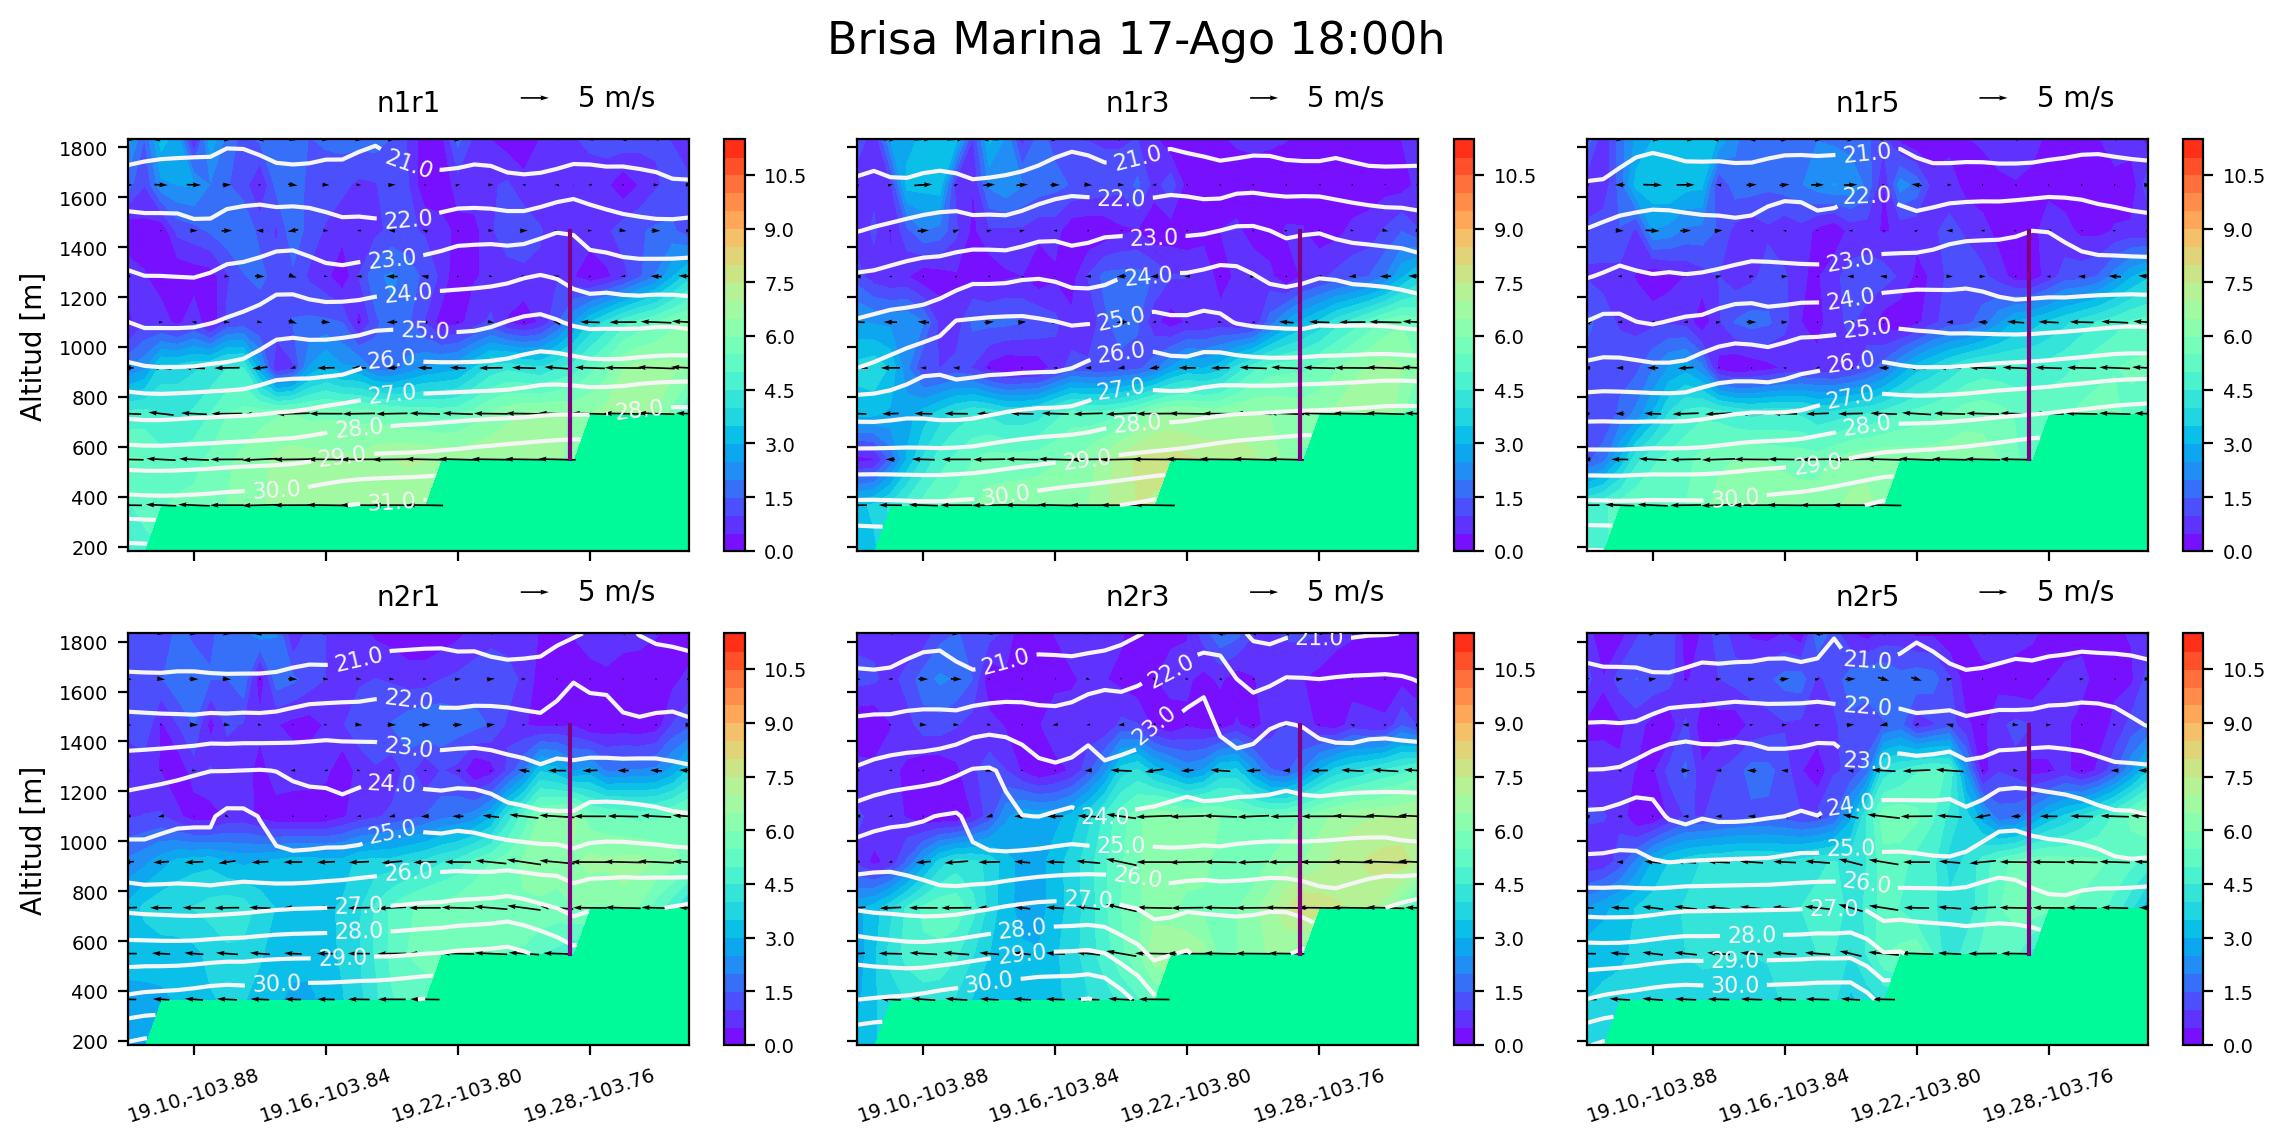

In [36]:
xp=6
tt=60
ang=30
vmax=12
hovtSBuv0(xp=xp,tt=tt,angle=ang,vmax=vmax,zbot=1,ztop=11)

ncwrf  2012-08-18T00:00:00.000000000 nclocalt  2012-08-17 18:00:00 sodart 2012-08-18 06:00:00


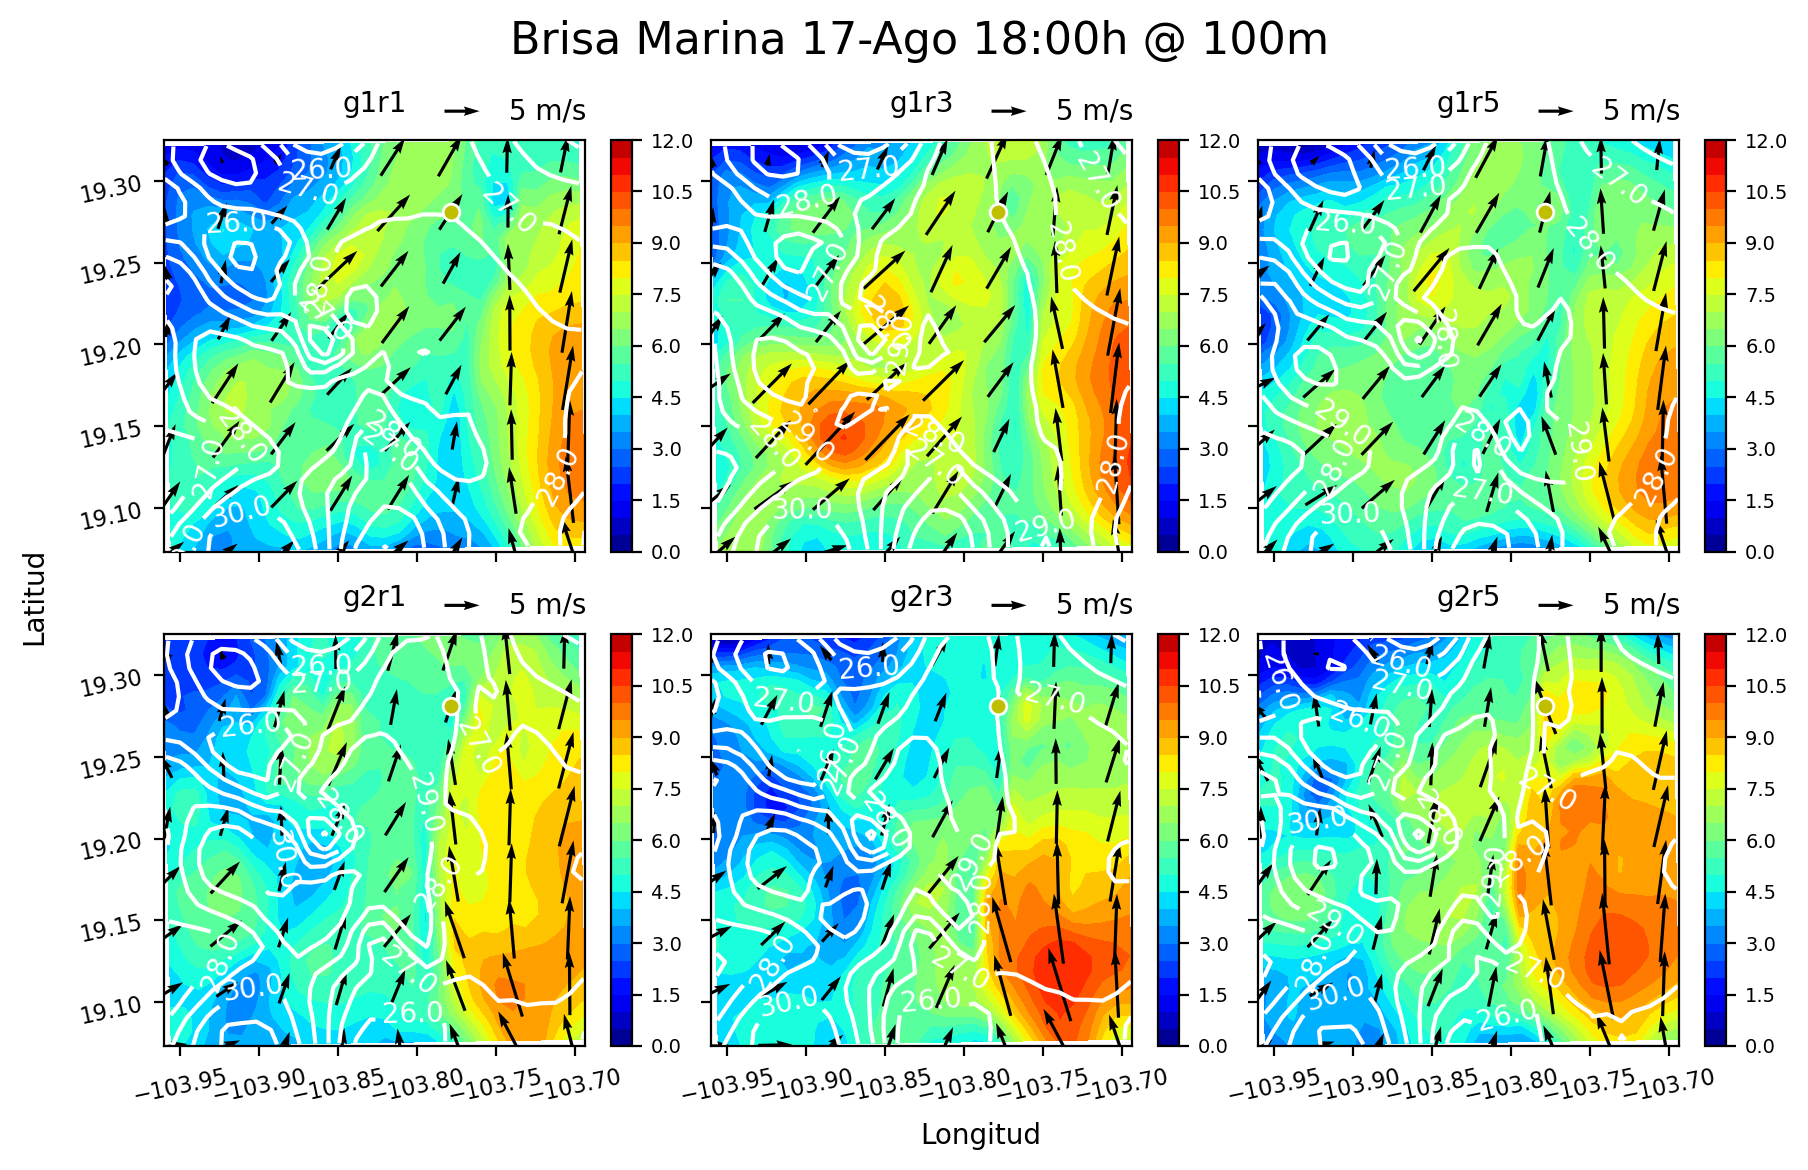

In [37]:
xp=0
tt=60
lev=3
vmax=12.5
levPlot6(xp,tt,lev,vmax)

ncwrf  2012-08-18T00:00:00.000000000 nclocalt  2012-08-17 18:00:00 sodart 2012-08-18 06:00:00


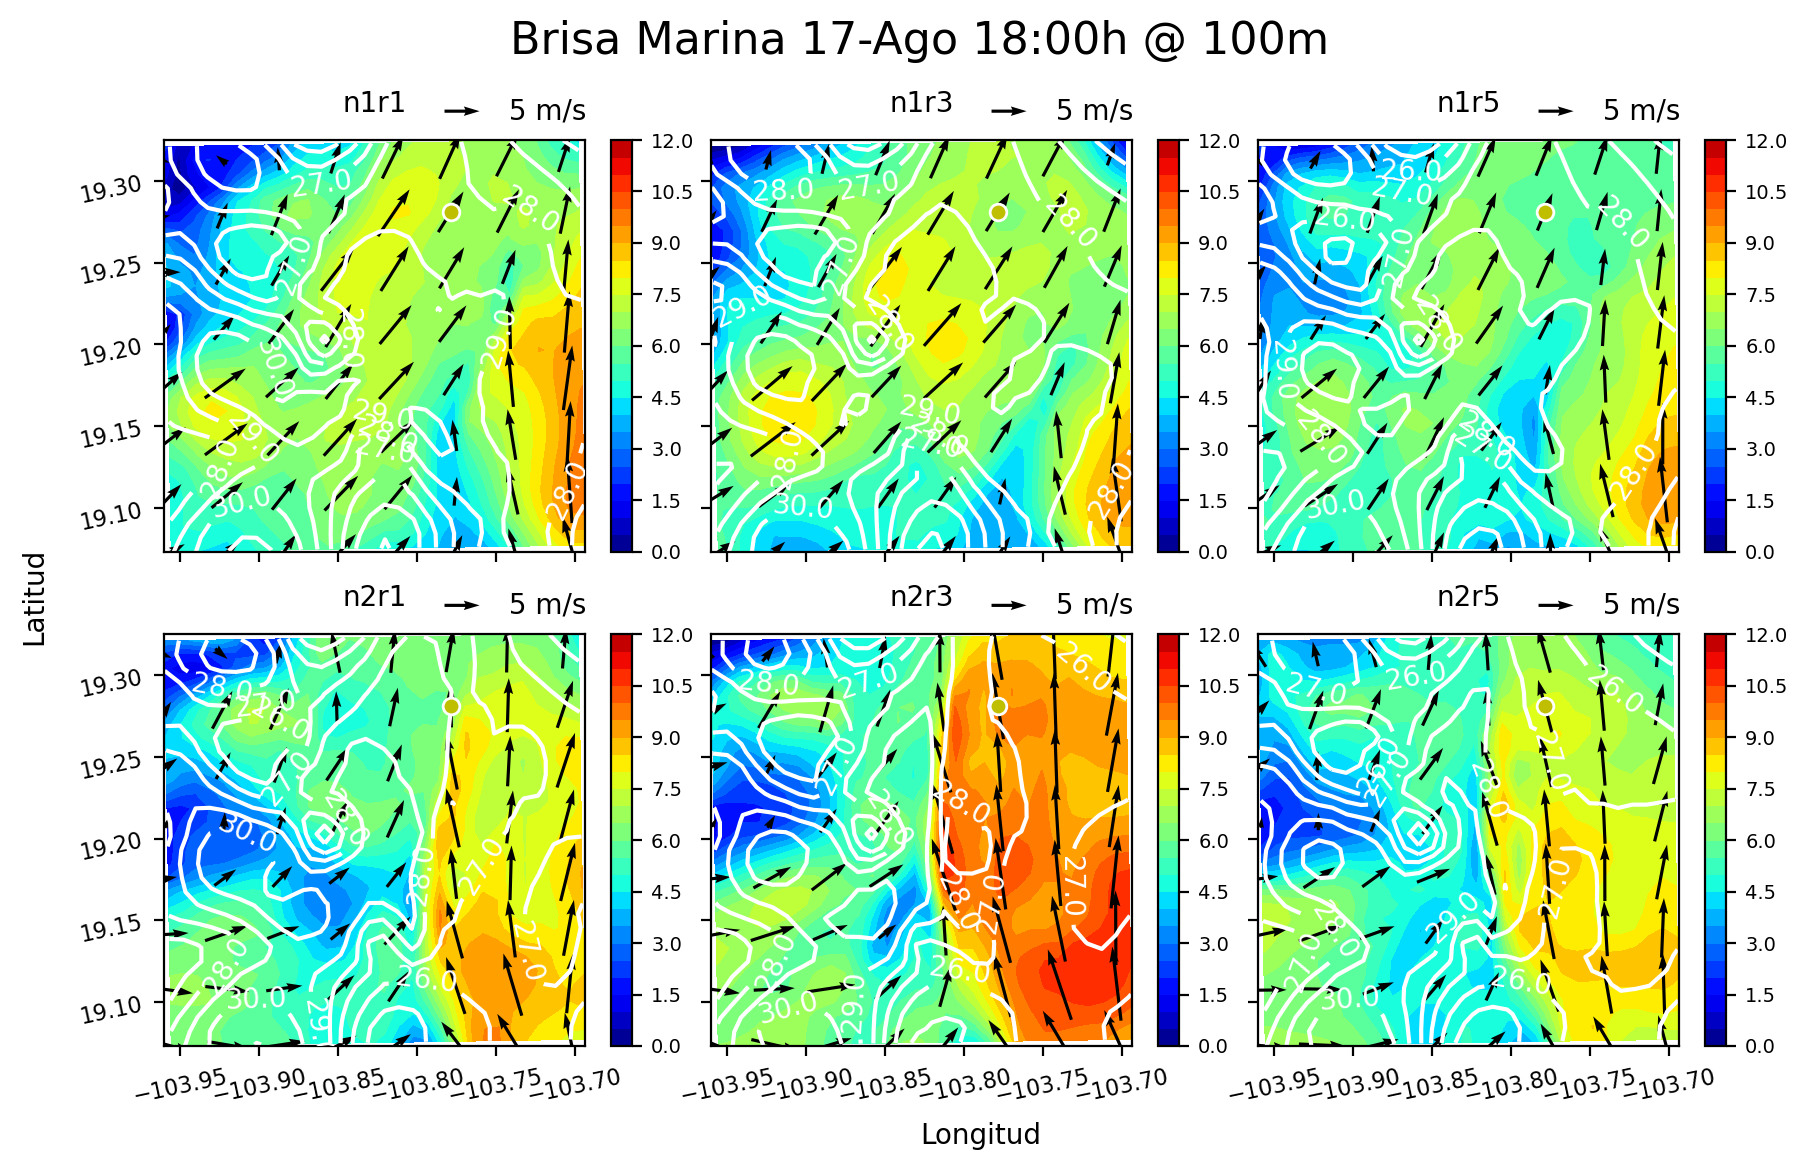

In [38]:
xp=6
tt=60
lev=3
vmax=12.5
levPlot6(xp,tt,lev,vmax)

ncwrf  2012-08-18T00:00:00.000000000 nclocalt  2012-08-17 18:00:00 sodart 2012-08-18 06:00:00


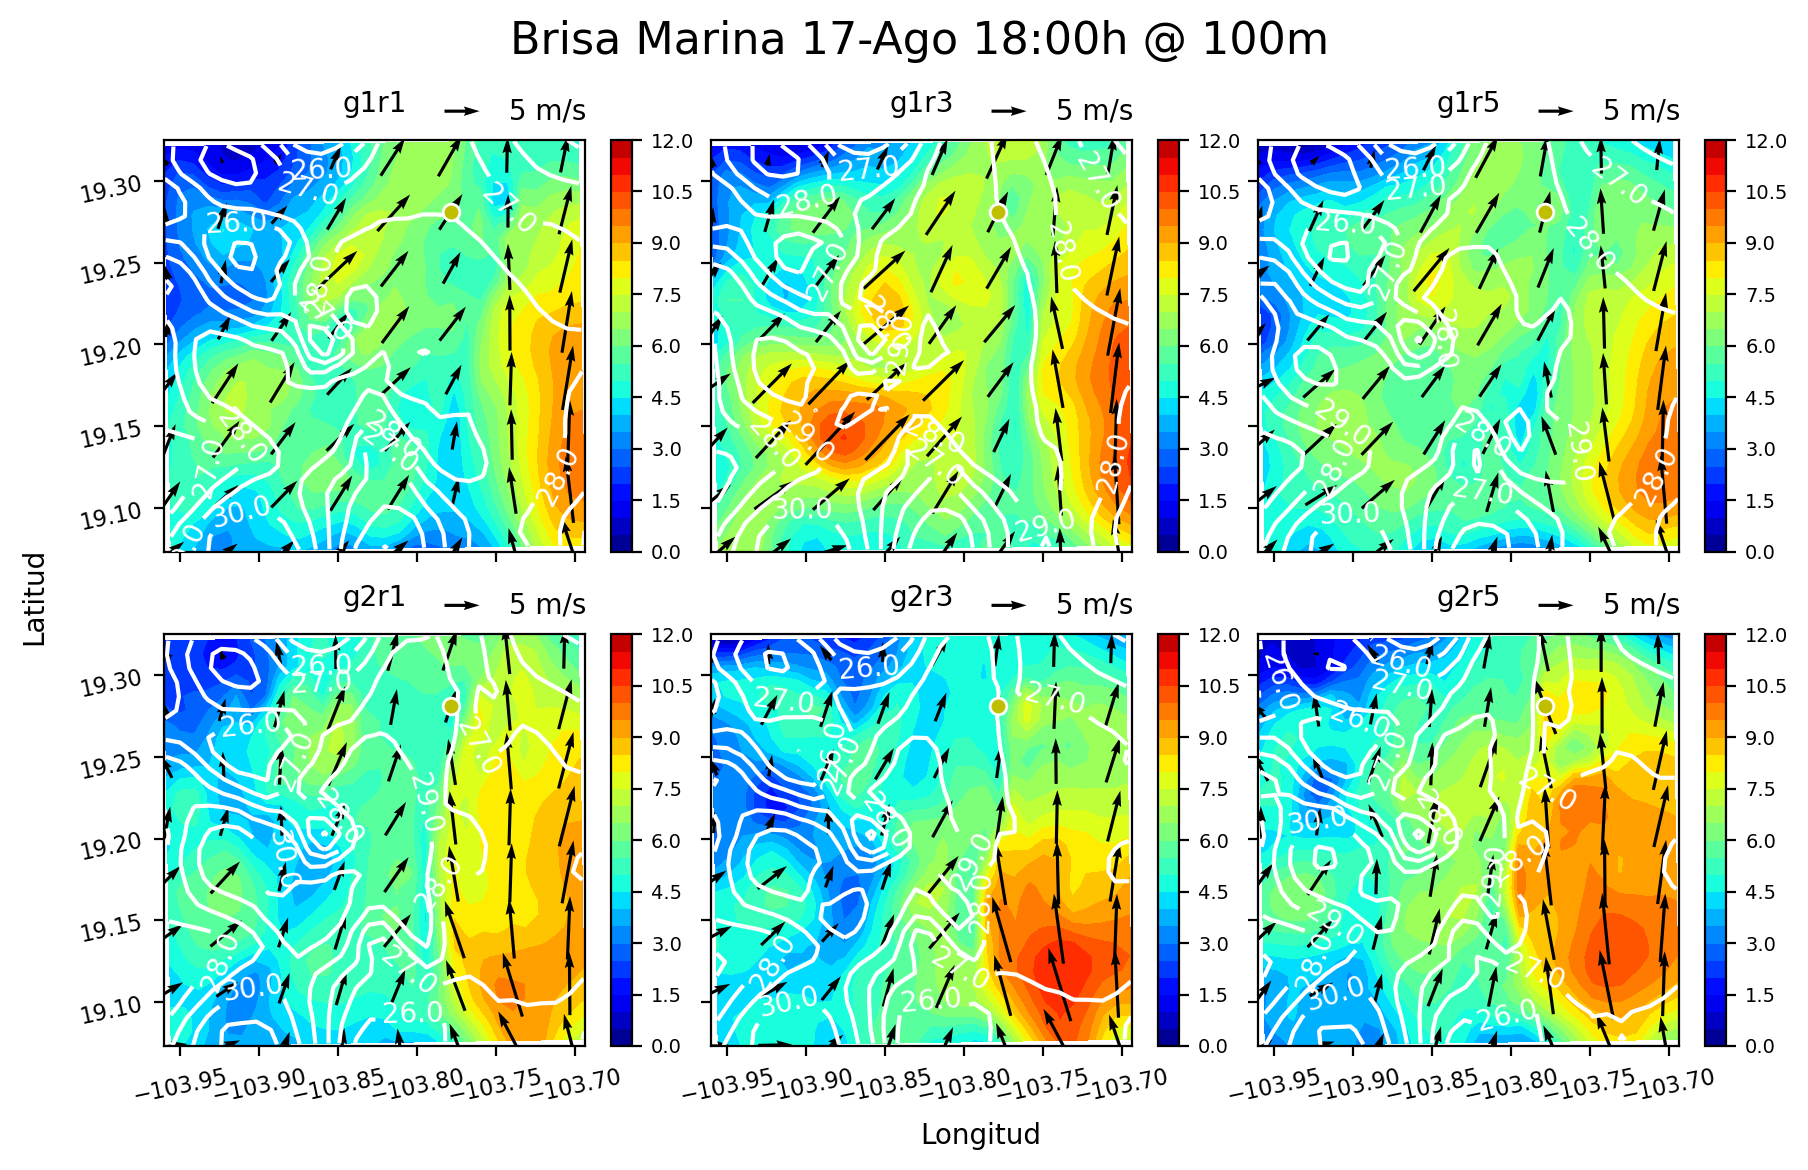

In [39]:
xp=0
tt=60
lev=3
vmax=12.5
levPlot6(xp,tt,lev,vmax)

ncwrf  2012-08-18T00:00:00.000000000 nclocalt  2012-08-17 18:00:00 sodart 2012-08-18 06:00:00


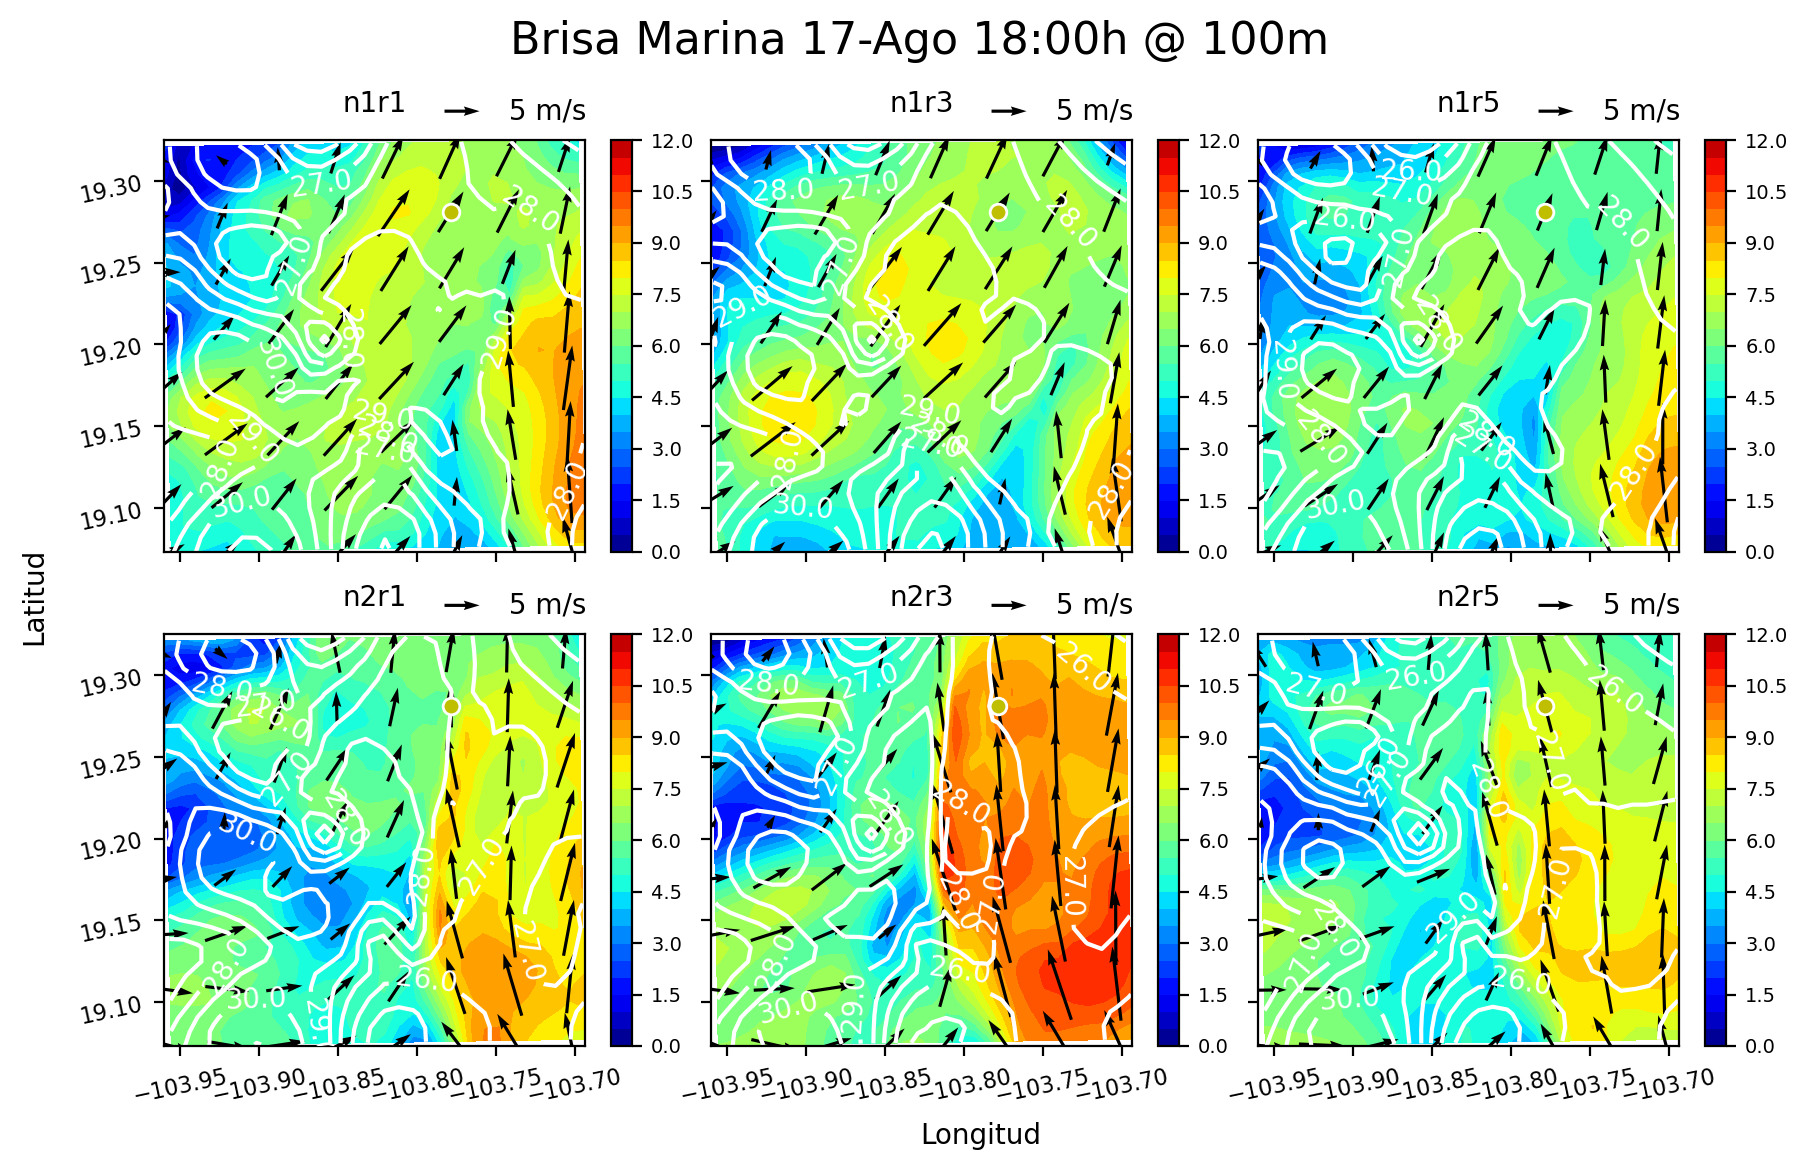

In [40]:
xp=6
tt=60
lev=3
vmax=12.5
levPlot6(xp,tt,lev,vmax)

ncwrf  2012-08-18T00:00:00.000000000 nclocalt  2012-08-17 18:00:00 sodart 2012-08-18 06:00:00


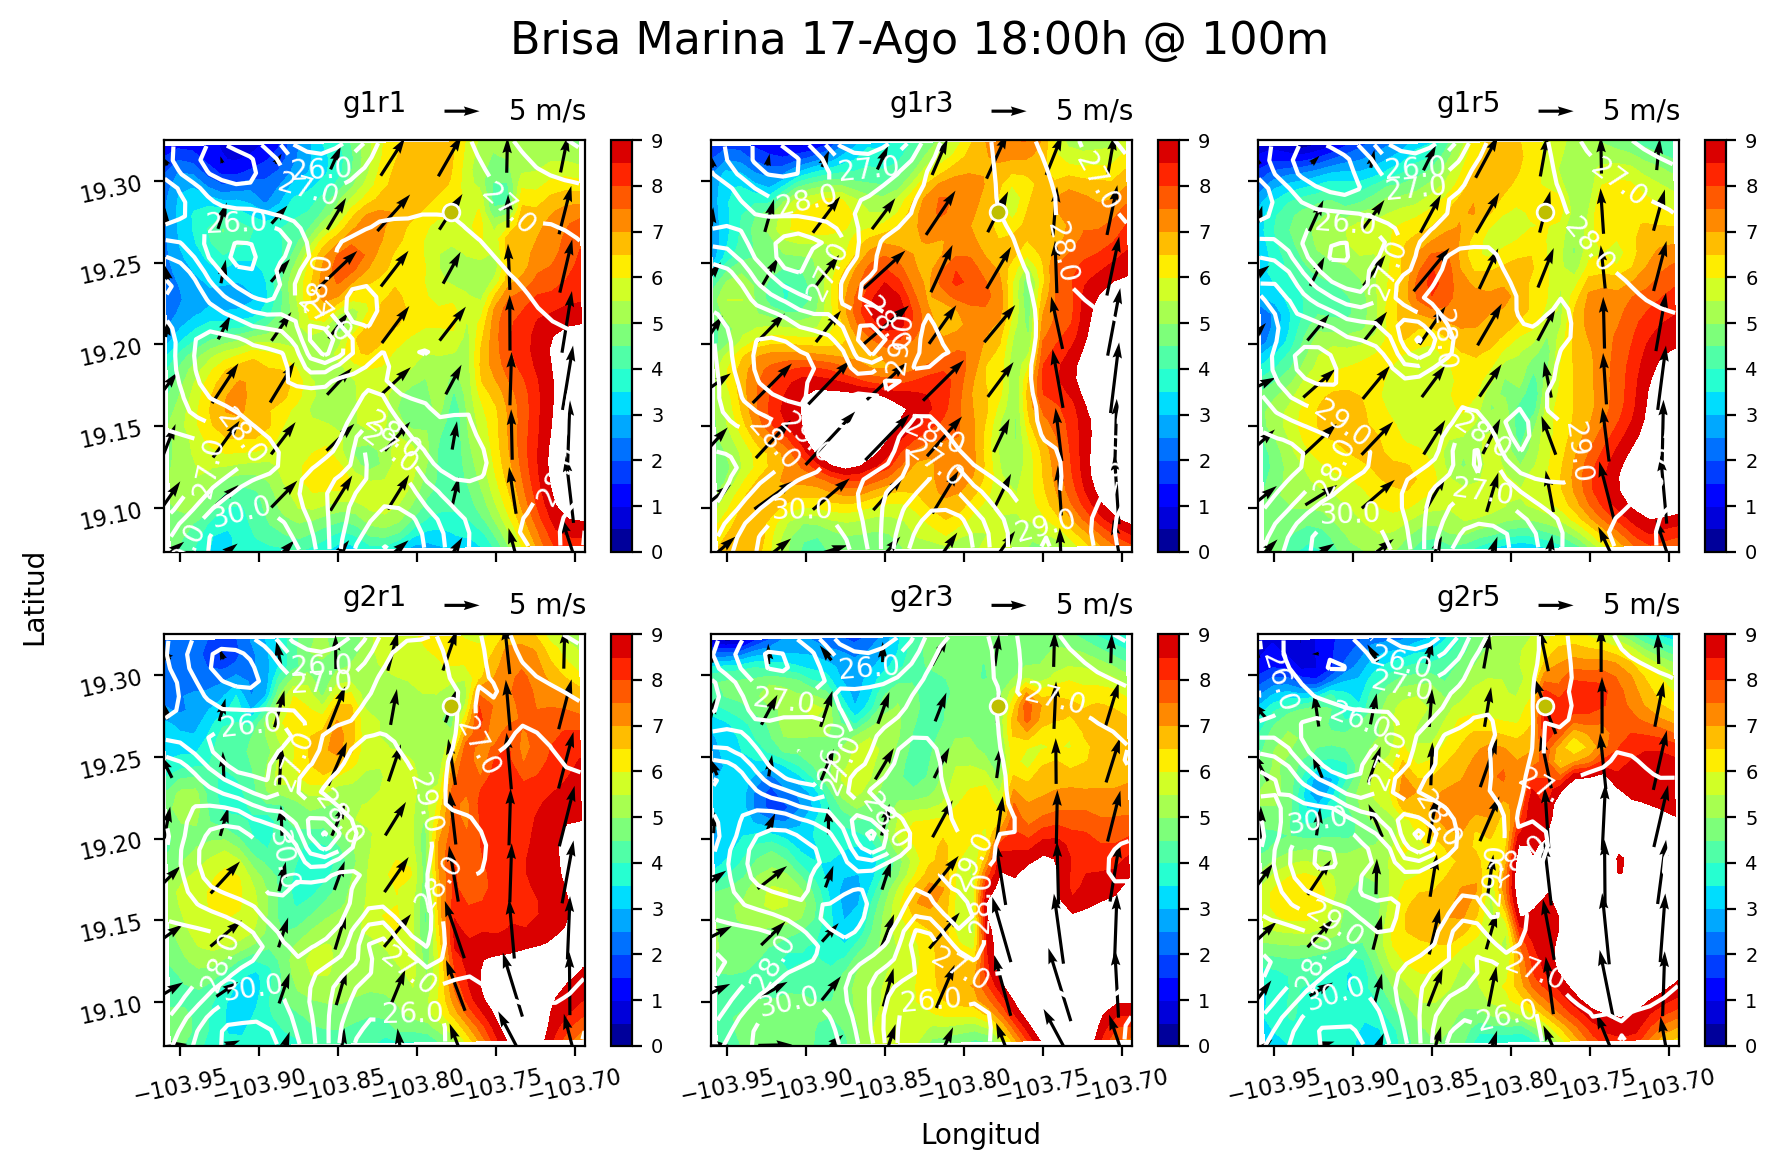

In [41]:
xp=0
tt=60
lev=3
vmax=9.5
levPlot6(xp,tt,lev,vmax)

ncwrf  2012-08-18T00:00:00.000000000 nclocalt  2012-08-17 18:00:00 sodart 2012-08-18 06:00:00


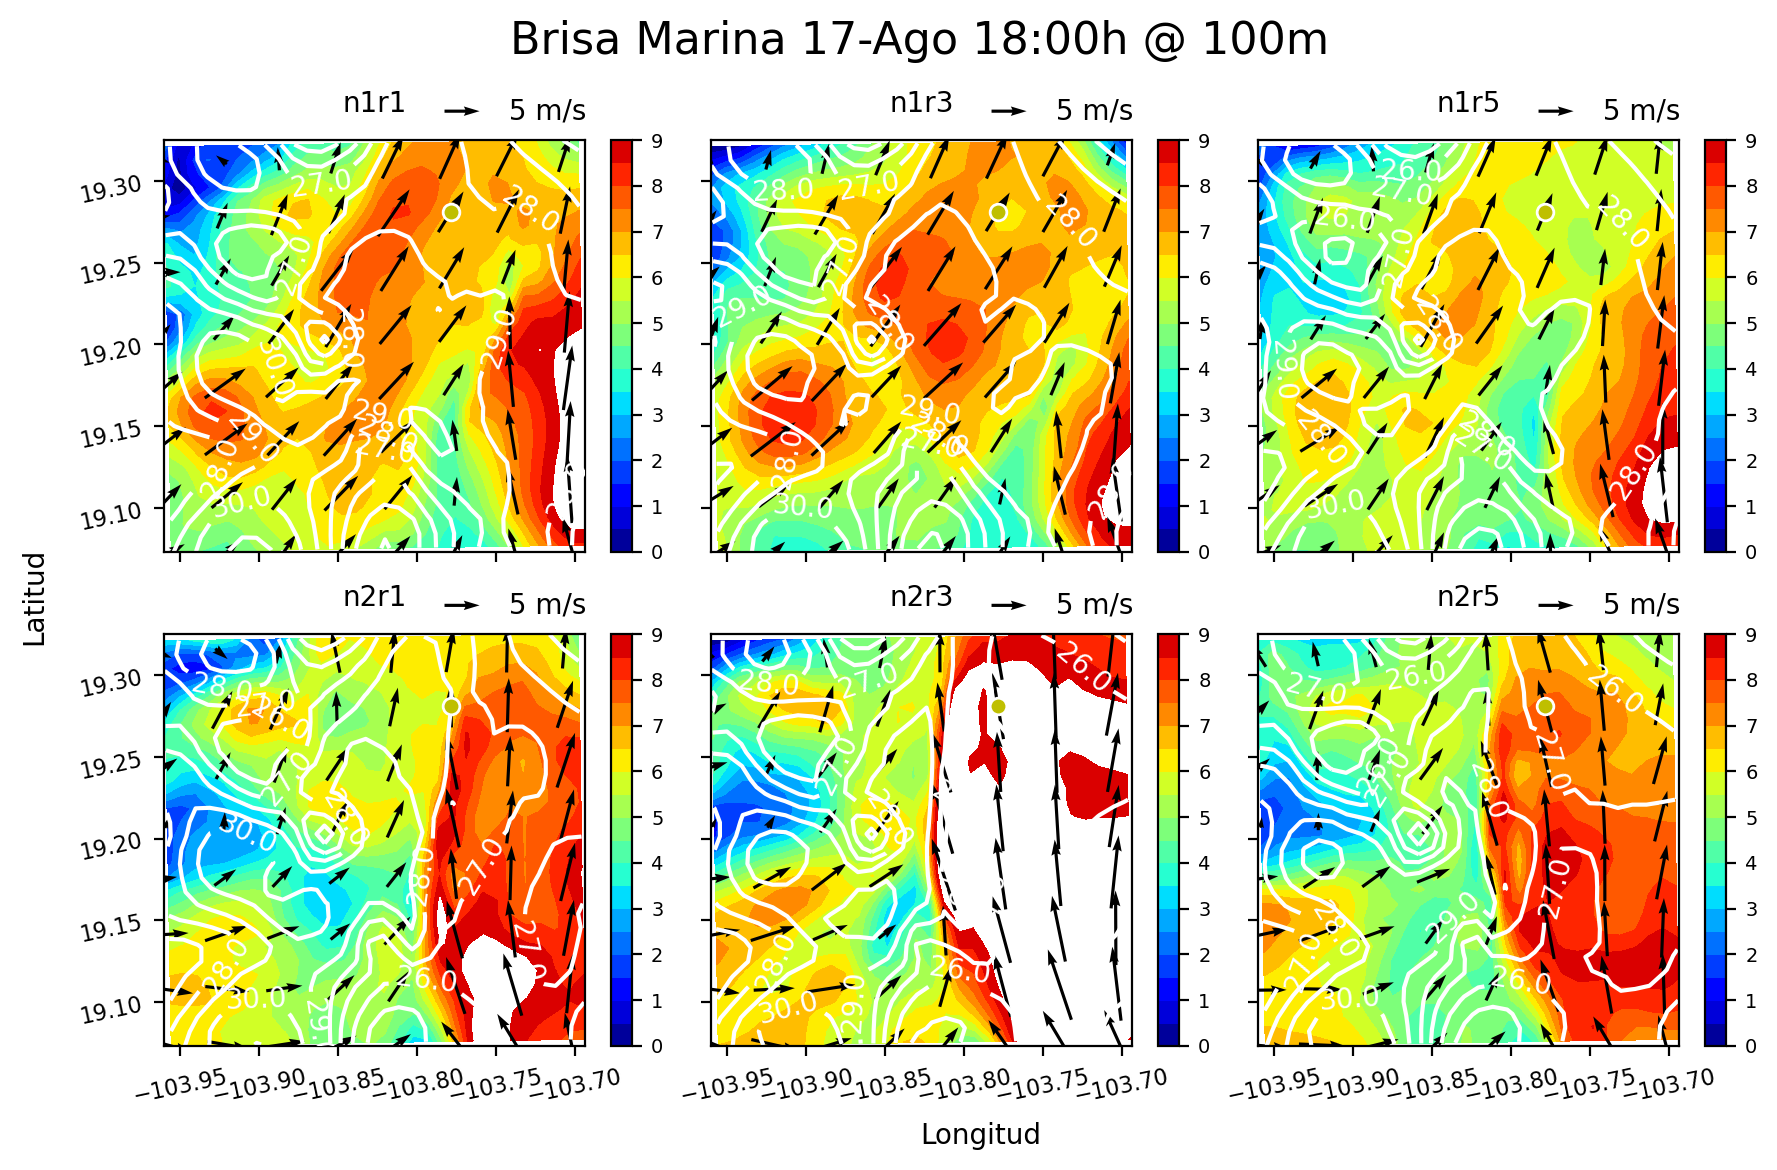

In [42]:
xp=6
tt=60
lev=3
vmax=9.5
levPlot6(xp,tt,lev,vmax)